# 0 Utils

In [1]:
import os
import numpy as np
import seaborn as sb
%matplotlib inline
sb.set()
import matplotlib.pyplot as plt
import pandas as pd

N_JOBS = -1
RANDOM_STATE = 42

## Experiment Setting 

In [2]:
import time
start_time = time.time()


In [3]:
# dataset, base nro 2
dataset_nro = 6
experiment_nro = 1
# 'All Proyects', 'Altos del Valle', 'Edificio Urban 1470','San Andres Del Valle', 'Edificio Mil610', 'Edificio Junge'
proyecto_select = 'All Proyects'

# base, base_profesion, base_minusisprofesion, base_medini_isrec
use_predictors = 'base'
# experimento 2 y 4 va con True
no_nulls = False

# 1 Load Dataset

In [4]:
# nombre experimento
exp_name = "{} {} Profit exp".format(proyecto_select, use_predictors)
# eleccion dataset
dataset = 'personas_cotizacion{}.csv'.format(dataset_nro)

# DS_NAME = dataset.split('.')[0]
DS_NAME = exp_name

folder = '..\\results\\model_results\\{}'.format(DS_NAME)

if not os.path.exists(folder):
    os.mkdir(folder)


personas = pd.read_csv('..\\..\\Datos\\experiments\\{}'.format(dataset), encoding = "ISO-8859-1")

readme = dict()
readme['experiment_name'] = DS_NAME
readme['experiment_dataset'] = dataset

print(personas.shape)
readme['personas_shape'] = personas.shape
# personas.head(2)

print(personas.columns)
readme['personas_columns'] = personas.columns.tolist()

(6184, 36)
Index(['Unnamed: 0', 'is_apellido1', 'is_appelido2', 'is_celular',
       'is_direccion', 'is_fnac', 'is_nombre', 'is_nombrecompleto',
       'is_nrofam', 'is_profesion', 'is_recontacto', 'is_telefono',
       'loc_comuna', 'loc_provincia', 'loc_region', 'max_rango_edad',
       'mean_cot_bod', 'mean_cot_depto', 'mean_cot_esta', 'mean_cot_estu',
       'medio_inicial', 'negocio', 'nro_cot_bod', 'nro_cot_depto',
       'nro_cot_esta', 'nro_cot_estu', 'nro_proyectos', 'profesion', 'rut',
       'sexo', 'tipo_cliente', 'Altos del Valle', 'Edificio Urban 1470',
       'San Andres Del Valle', 'Edificio Mil610', 'Edificio Junge'],
      dtype='object')


In [5]:
personas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6184 entries, 0 to 6183
Data columns (total 36 columns):
Unnamed: 0              6184 non-null int64
is_apellido1            6184 non-null bool
is_appelido2            6184 non-null bool
is_celular              6184 non-null bool
is_direccion            6184 non-null bool
is_fnac                 6184 non-null bool
is_nombre               6184 non-null bool
is_nombrecompleto       6184 non-null bool
is_nrofam               6184 non-null bool
is_profesion            6184 non-null bool
is_recontacto           6184 non-null bool
is_telefono             6184 non-null bool
loc_comuna              6184 non-null object
loc_provincia           6184 non-null object
loc_region              6184 non-null object
max_rango_edad          6184 non-null float64
mean_cot_bod            6184 non-null float64
mean_cot_depto          6184 non-null float64
mean_cot_esta           6184 non-null float64
mean_cot_estu           6184 non-null float64
medio_inici

In [6]:
personas['loc_comuna'] = personas['loc_comuna'].astype('category')
personas['loc_provincia'] = personas['loc_provincia'].astype('category')
personas['loc_region'] = personas['loc_region'].astype('category')
personas['tipo_cliente'] = personas['tipo_cliente'].astype('category')
personas['sexo'] = personas['sexo'].astype('category')
personas.profesion.fillna('sin informacion', inplace=True)
personas['profesion'] = personas['profesion'].astype('category')
personas['medio_inicial'] = personas['medio_inicial'].astype('category')

In [7]:
personas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6184 entries, 0 to 6183
Data columns (total 36 columns):
Unnamed: 0              6184 non-null int64
is_apellido1            6184 non-null bool
is_appelido2            6184 non-null bool
is_celular              6184 non-null bool
is_direccion            6184 non-null bool
is_fnac                 6184 non-null bool
is_nombre               6184 non-null bool
is_nombrecompleto       6184 non-null bool
is_nrofam               6184 non-null bool
is_profesion            6184 non-null bool
is_recontacto           6184 non-null bool
is_telefono             6184 non-null bool
loc_comuna              6184 non-null category
loc_provincia           6184 non-null category
loc_region              6184 non-null category
max_rango_edad          6184 non-null float64
mean_cot_bod            6184 non-null float64
mean_cot_depto          6184 non-null float64
mean_cot_esta           6184 non-null float64
mean_cot_estu           6184 non-null float64
medio

In [8]:
# personas['negocio'] = ['negocio' if x == True else 'no negocio' for x in personas.negocio]
# personas.negocio.unique()

In [9]:
# tab_info=pd.DataFrame(personas.dtypes).T.rename(index={0:'column type'})
# tab_info=tab_info.append(pd.DataFrame(personas.isnull().sum()).T.rename(index={0:'null values (nb)'}))
# tab_info=tab_info.append(pd.DataFrame(personas.isnull().sum()/personas.shape[0]*100).T.rename(index={0:'null values (%)'}))
# display(tab_info)

In [10]:
# personas.hist(figsize=(20,10))

In [11]:
predictors_set = dict()

base = ['is_apellido1', 'is_appelido2', 'is_celular',
       'is_direccion', 'is_fnac', 'is_nombre', 'is_nombrecompleto',
       'is_nrofam', 'is_profesion', 'is_telefono',
       'loc_comuna', 'loc_provincia', 'loc_region',
       'mean_cot_bod', 'mean_cot_depto', 'mean_cot_esta', 'mean_cot_estu',
       'nro_cot_bod', 'nro_cot_depto',
       'nro_cot_esta', 'nro_cot_estu', 'nro_proyectos',
       'sexo', 'tipo_cliente', 
#         'Altos del Valle', 
        'Edificio Urban 1470',
       'San Andres Del Valle', 
        'Edificio Mil610', 
        'Edificio Junge']

print(len(base))
predictors_set ['base'] = base

base_profesion = base[0:]
base_profesion.append('profesion')
print(len(base_profesion))
predictors_set ['base_profesion'] = base_profesion

base_minusisprofesion = base_profesion[0:]
base_minusisprofesion.remove('is_profesion')
print(len(base_minusisprofesion))
predictors_set ['base_minusisprofesion'] = base_minusisprofesion

base_medini_isrec = base_profesion[0:]
base_medini_isrec.append('medio_inicial')
base_medini_isrec.append('is_recontacto')
print(len(base_medini_isrec))
predictors_set ['base_medini_isrec'] = base_medini_isrec


28
29
28
31


In [12]:
# Ajustes especificos experimento
# Para E5D5, E6D5 #########################################
if proyecto_select != 'All Proyects':
    mask = (personas[proyecto_select] > 0)
    personas = personas[mask]
    print(personas[mask].shape)
    personas[mask]
###########################################################

predictors = predictors_set[use_predictors]

# print(personas[personas['profesion']=='sin informacion'].shape)
# print(personas.profesion.nunique())
# print(personas.is_profesion.unique())

# En que experimento use esto? E8D6 y E28D6
# Se usa en los experimentos de data set limpio para evaluar con las personas que si entregaron la profesion
# personas.replace(['sin informacion'], np.nan, inplace=True)
# personas.dropna(inplace=True)
if no_nulls:
    personas.replace(['sin informacion'], np.nan, inplace=True)
    personas.dropna(inplace=True)

In [13]:
# Ready Data Set
p_negocio = personas.negocio # Target
# personas = personas.drop(drop_columns, axis=1) # Predictors
personas = personas[predictors]

print(p_negocio.shape)
print(personas.shape)
readme['personas_after_drop_columns'] = personas.columns

print(personas.shape)
readme['personas_predictors_shape'] = personas.shape
readme['personas_predictors'] = personas.columns


personas = pd.get_dummies(personas)
readme['personas_dummies_shape'] = personas.shape

# personas.describe()

(6184,)
(6184, 28)
(6184, 28)


## Correlacion 

In [14]:
# from scipy.stats.stats import pearsonr, spearmanr, kendalltau
# corr_p = personas.corr(method='pearson')

# import seaborn as sns
# f = plt.figure(figsize=(40,20))
# g = sns.heatmap(corr_p, annot=True).get_figure()
# g.savefig('..\\img\\time_series_corr.png')

In [15]:
# from sklearn.feature_selection import VarianceThreshold
# vt = VarianceThreshold()
# personas_vt = vt.fit_transform(personas)

In [16]:
# print(personas_vt.shape)
# print(vt.variances_)

# 3 Supervised Learning: Classification

## 3.1 Libraries

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

## 3.2 Check the Dataset

In [18]:
print("Tamaño Total: ", personas.shape)
print("Personas que hicieron Negocio: ", p_negocio[p_negocio == True].shape)
print("Personas que no Hicieorn Negocio: ", p_negocio[p_negocio == False].shape)
readme['personas_negocio'] = p_negocio[p_negocio == True].shape
readme['personas_nonegocio'] = p_negocio[p_negocio == False].shape

Tamaño Total:  (6184, 43)
Personas que hicieron Negocio:  (1101,)
Personas que no Hicieorn Negocio:  (5083,)


In [19]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2

# transformer = SelectKBest(score_func=chi2,k=10)
# Xt_chi2 = transformer.fit_transform(X,y)
# print(Xt_chi2.shape)
# print(transformer.scores_)

## 3.3 Train & Test

In [20]:
X = personas
y = p_negocio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
readme['x_train_shape'] = X_train.shape
readme['y_train_shape'] = y_train.shape
readme['x_test_shape'] = X_test.shape
readme['y_test_shape'] = y_test.shape

(4328, 43) (1856, 43) (4328,) (1856,)


## 3.4 Help Functions

In [21]:
readme['model'] = dict()

In [22]:
roc_curves_to_plot= dict()

In [23]:
roc_curves_to_plot[DS_NAME]= dict()

In [24]:
import json
def save_readme():    
    exDict = {'readme': readme}
    with open('..\\results\\model_results\\{}\\readme_{}.txt'.format(DS_NAME, DS_NAME), 'w') as file:
        file.write(str(exDict))

def plot_all_auc_values():
        
    d = dict()
    for key in roc_curves_to_plot[DS_NAME]:
        d[key] = roc_curves_to_plot[DS_NAME][key]['auc']
    
    s = [(k, d[k]) for k in sorted(d, key=d.get, reverse=True)]
    
    x_model = [x[0] for x in s]
    x_value = [x[1] for x in s]
    
    x = np.arange(len(roc_curves_to_plot[DS_NAME].keys()))
    
    plt.title('{} AUC Models'.format(DS_NAME))
    plt.xlabel('Models')
    plt.ylabel('AUC')
    plt.bar(x, x_value)
    plt.xticks(x, x_model)
    plt.savefig('..\\results\\model_results\\{}\\auc_models.png'.format(DS_NAME,DS_NAME), dpi=300)
    plt.show()

def plot_all_roc_curves():
    plt.plot([0, 1], [0, 1], 'k--')
    
    for key in roc_curves_to_plot[DS_NAME]:
        plt.plot(roc_curves_to_plot[DS_NAME][key]['fpr'], roc_curves_to_plot[DS_NAME][key]['tpr']) #fpr and tpr
    
    legends = ['random choice']
    legends.extend(roc_curves_to_plot[DS_NAME].keys())
    plt.legend(legends)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} Models ROC Curve'.format(DS_NAME))
    plt.savefig('..\\results\\model_results\\{}\\roc_curve_all.png'.format(DS_NAME, MODEL), dpi=300)
    plt.show()

# Import necessary modules
def roc_curve_plot(model, X_test, y_test):
    
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = model.predict_proba(X_test)[:,1]

    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, treshold = roc_curve(y_test, y_pred_prob)
    
    roc_curves_to_plot[DS_NAME][MODEL] = dict()
    roc_curves_to_plot[DS_NAME][MODEL]['fpr'] = fpr
    roc_curves_to_plot[DS_NAME][MODEL]['tpr'] = tpr
    roc_curves_to_plot[DS_NAME][MODEL]['auc'] = roc_auc_score(y_test, y_pred_prob)
    
    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} {} ROC Curve'.format(DS_NAME, MODEL))
    plt.savefig('..\\results\\model_results\\{}\\{}_roc_curve.png'.format(DS_NAME, MODEL), dpi=300)
    plt.show()

def plot_confusion_matrix(model, X, y, y_pred):
    print(confusion_matrix(y, y_pred))
    readme['model'][MODEL]['conf_matrix'] = confusion_matrix(y, y_pred)
    
    print(classification_report(y, y_pred))
    readme['model'][MODEL]['cla_report'] = classification_report(y, y_pred)
    
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(5,5))
    
    sb.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    title_plt = "{} {} Conf. Matrix".format(DS_NAME, MODEL)
    plt.title(title_plt, size=10);
    plt.savefig('..\\results\\model_results\\{}\\{}_confusion_matrix.png'.format(DS_NAME, MODEL), dpi=300)
    plt.show()

def plot_importance_graph(model):
    features = personas.columns
    
    feature_importance = model.best_estimator_.feature_importances_ 
    fig = plt.figure(figsize=(20, 18))
    ax = fig.add_subplot(111)

    df_f = pd.DataFrame(feature_importance, columns=["importance"])
    df_f["labels"] = features
    df_f.sort_values("importance", inplace=True, ascending=False)
    display(df_f.head(5))

    index = np.arange(len(feature_importance[:20]))
    bar_width = 0.5
    rects = plt.barh(index[:20] , df_f["importance"][:20], bar_width, alpha=0.4, color='b', label='Main')
    plt.yticks(index, df_f["labels"])
    plt.title("{} {} Feature Importance".format(DS_NAME, MODEL))
    plt.savefig('..\\results\\model_results\\{}\\{}_importance.png'.format(DS_NAME, MODEL), dpi=300)
    plt.show()

def grid_results(grid, plot_roc_curve=True):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

    best_model = grid.best_estimator_
    best_model.fit(X_train,y_train)
#     mse = mean_squared_error(y_test, best_model.predict(X_test))
#     print( 'MSE: '+ str(mse))
#     print( 'RMSE: '+  str(np.sqrt(mse)))
    
    readme['model'][MODEL]['name'] = MODEL
    readme['model'][MODEL]['best_estimator'] = grid.best_estimator_
    readme['model'][MODEL]['best_score'] = grid.best_score_
    
    print("Best score is {}".format(grid.best_score_))
    
    y_pred = best_model.predict(X_test)
    
    # Confusion Matrix
    print()
    plot_confusion_matrix(best_model, X_test, y_test, y_pred)
    
    #Update Exec Time
    readme['time_exec'] = time.time() - start_time
    
    #Update README
    save_readme()
    
    #ROC Curve
    if plot_roc_curve:
        roc_curve_plot(best_model, X_test, y_test)

## 3.5 Models

In [25]:
to_profit_curve = dict()

0.8507543103448276
[[1321  200]
 [  77  258]]
             precision    recall  f1-score   support

      False       0.94      0.87      0.91      1521
       True       0.56      0.77      0.65       335

avg / total       0.88      0.85      0.86      1856



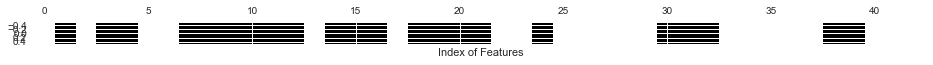

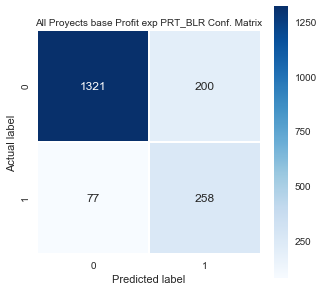

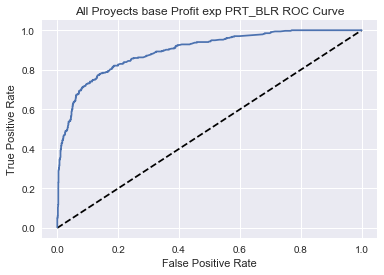

In [26]:
MODEL = 'PRT_BLR'
readme['model'][MODEL] = dict()

to_profit_curve[MODEL] = dict()

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=12, max_features=13,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=RANDOM_STATE,
            verbose=0, warm_start=False)

select = SelectFromModel(rf, threshold='median')

select.fit(X_train, y_train)
X_train_s = select.transform(X_train)

mask = select.get_support()
plt.matshow(mask.reshape(1,-1), cmap='gray_r')
plt.xlabel('Index of Features')

X_test_s = select.transform(X_test)

log = LogisticRegression(C=0.4393970560760795, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=RANDOM_STATE,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

to_profit_curve[MODEL]['model'] = log
log.fit(X_train_s, y_train)
score = log.score(X_test_s, y_test)
print(score)

plot_confusion_matrix(log, X_test_s, y_test, log.predict(X_test_s))
roc_curve_plot(log, X_test_s, y_test)

In [27]:
log.fit(X_train_s, y_train)
# y_pred = log.predict(X_test_s)

# log.fit(X_train_s, y_train)
# predict = model.predict(X_test_s)
predict_probabilities = log.predict_proba(X_test_s)[:,1]


fpr, tpr, _ = roc_curve(y_test, predict_probabilities)

predict_mine = np.where(predict_probabilities > 0.2, 1, 0)
confusion_matrix(y_test, predict_mine)

array([[897, 624],
       [ 24, 311]], dtype=int64)

In [28]:
# predict_probabilities

In [29]:
probs = log.predict_proba(X_test_s)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)

roc_auc = metrics.auc(fpr, tpr)

bla = dict()
bla['fpr'] = fpr
bla['tpr'] = tpr

bla['threshold'] = threshold
# bla
col = ['fpr', 'tpr', 'threshold']
df = pd.DataFrame.from_records(bla, columns=col)
# print(df.head())
# print(df.tail(30))

In [30]:
# import matplotlib.pyplot as plt
# plt.title('Receiver Operating Characteristic')
# plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

# KNeighbors

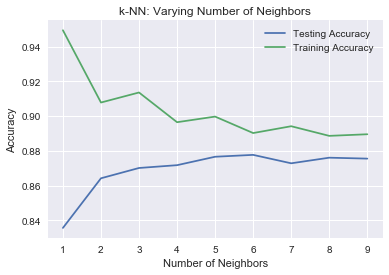

In [31]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 10)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=N_JOBS)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()


# KNeighbors

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')
           
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Best Params:  {'n_neighbors': 9}
Best Estimator:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')
Best score is 0.8816300129366106

[[1473   48]
 [ 165  170]]
             precision    recall  f1-score   support

      False       0.90      0.97      0.93      1521
       True       0.78      0.51      0.61       335

avg / total       0.88      0.89      0.88      1856



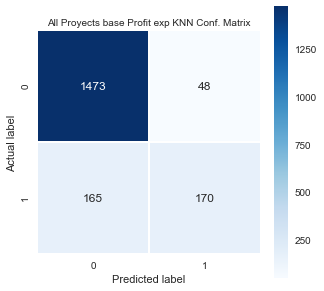

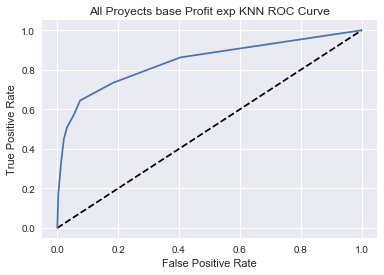

In [32]:
MODEL = 'KNN'
readme['model'][MODEL] = dict()
from sklearn.metrics import mean_squared_error
X = MinMaxScaler().fit_transform(X)

# Instantiate a k-NN classifier: knn
knn = KNeighborsClassifier()

# Param Grid
param_grid = {'n_neighbors': np.arange(1, 10)}

# Stratified
from sklearn.model_selection import GridSearchCV, StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# GridSearch
knn_cv = GridSearchCV(knn, param_grid, cv=kf, n_jobs=N_JOBS)
knn_cv.fit(X,y)


print("Best Params: ", knn_cv.best_params_)

print('Best Estimator: ', knn_cv.best_estimator_)



grid_results(knn_cv)

# PCA + KNN

TN -> 81:
[('pca', PCA(copy=True, iterated_power='auto', n_components=9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)),
('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
metric_params=None, n_jobs=1, n_neighbors=5, p=2, weights='uniform'))]

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.6s finished


Best parameters set:  {'memory': None, 'steps': [('pca', PCA(copy=True, iterated_power='auto', n_components=9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))], 'pca': PCA(copy=True, iterated_power='auto', n_components=9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 'clf': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'), 'pca__copy': True, 'pca__iterated_power': 'auto', 'pca__n_components': 9, 'pca__random_state': None, 'pca__svd_solver': 'auto', 'pca__tol': 0.0, 'pca__whiten': False, 'clf__algorithm': 'auto', 'clf__leaf_size': 30, 'clf__metric': 'minkowski', 'clf__metric_params': None, 'clf__n_jobs': 1, 'clf__n_neighbors': 5, 'clf__p': 2, 'clf__weights': 'uniform'}


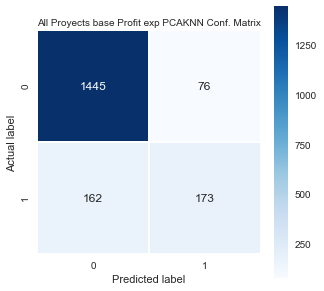

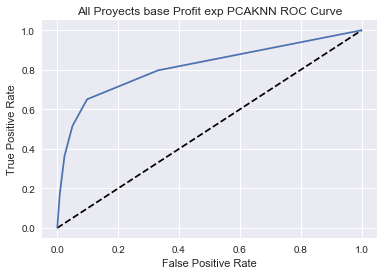

In [33]:
MODEL = 'PCAKNN'
readme['model'][MODEL] = dict()
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.svm import LinearSVC 

pipe = Pipeline([
    ('pca', PCA()),
    ('clf', KNeighborsClassifier()),
])

parameters = {
    'pca__n_components': [2, 3, 4, 5, 6, 7, 8, 9],
    #'clf__C': [1, 10, 100],
    }

from sklearn.model_selection import GridSearchCV, StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

gs = GridSearchCV(pipe, parameters, cv=kf, n_jobs=N_JOBS, verbose=1)
gs.fit(X, y)

best_parameters = gs.best_estimator_.get_params()
print("Best parameters set: ",best_parameters)
print('Best Estimator: ', gs.best_estimator_)
    
    
grid_results(gs)
# print("Best score: %0.3f" % gs.best_score_)


# y_pred = gs.predict(X_test) 
# # results(y_pred, y)

# plot_confusion_matrix(gs,X_test,y_test,y_pred)
# roc_curve_plot(gs, X_test, y_test)

# LogisticRegression

LogisticRegression(C=3.727593720314938, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
          
          
          
LogisticRegression(C=3.727593720314938, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Best score is 0.8921410090556274

## Grid

Tuned Logistic Regression Parameters: {'C': 31.622776601683793, 'penalty': 'l2'}
Best Estimator:  LogisticRegression(C=31.622776601683793, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Best score is 0.8929495472186287

[[1464   57]
 [ 143  192]]
             precision    recall  f1-score   support

      False       0.91      0.96      0.94      1521
       True       0.77      0.57      0.66       335

avg / total       0.89      0.89      0.89      1856



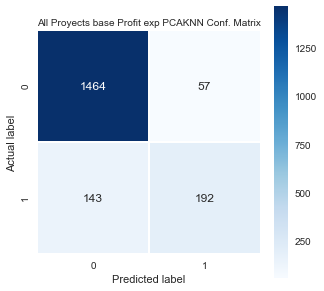

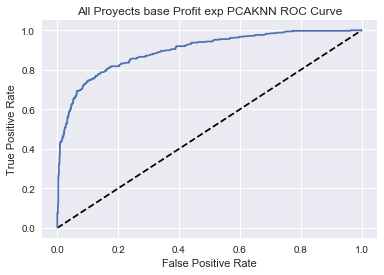

ROC AUC Score: 0.7746729861540425


In [34]:
X = MinMaxScaler().fit_transform(X)

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
C = np.logspace(0, 4, 10)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}


# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression(class_weight=None)
# logreg = LogisticRegression()

# Stratified
from sklearn.model_selection import GridSearchCV, StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=kf, n_jobs=N_JOBS)
logreg_cv.fit(X, y)

# # Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
print('Best Estimator: ', logreg_cv.best_estimator_)
# print("Best score is {}".format(logreg_cv.best_score_))
# Fit it to the data
grid_results(logreg_cv)
# # 
y_pred_prob = logreg_cv.predict_proba(X_test)[:,1]

print("ROC AUC Score:" ,roc_auc_score(y_test,y_pred_prob))

## LR Unbalanced

(4328, 43) (1856, 43) (4328,) (1856,)
0.890625
[[1465   56]
 [ 147  188]]
             precision    recall  f1-score   support

      False       0.91      0.96      0.94      1521
       True       0.77      0.56      0.65       335

avg / total       0.88      0.89      0.88      1856



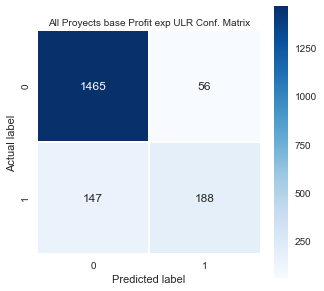

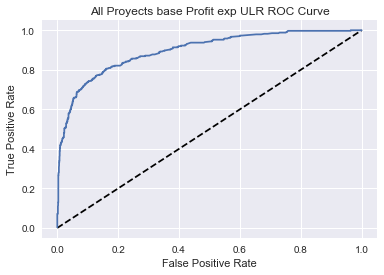

In [35]:
MODEL = 'ULR'
readme['model'][MODEL] = dict()
to_profit_curve[MODEL] = dict()

# Balanced Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
print(X_train.shape,X_test.shape,y_train.shape, y_test.shape)

model = LogisticRegression(C=3.727593720314938, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=RANDOM_STATE,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

to_profit_curve[MODEL]['model'] = model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(model.score(X_test, y_test))
plot_confusion_matrix(model, X_test, y_test, y_pred)

#ROC Curve
roc_curve_plot(model, X_test, y_test)

## LR Balanced

(4328, 43) (1856, 43) (4328,) (1856,)
0.8485991379310345
[[1318  203]
 [  78  257]]
             precision    recall  f1-score   support

      False       0.94      0.87      0.90      1521
       True       0.56      0.77      0.65       335

avg / total       0.87      0.85      0.86      1856



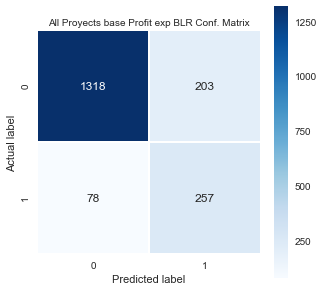

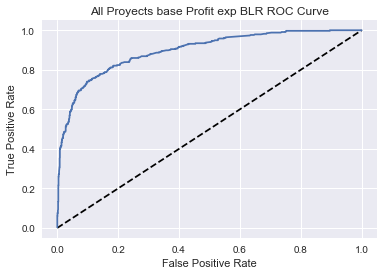

In [36]:
MODEL = 'BLR'
readme['model'][MODEL] = dict()
to_profit_curve[MODEL] = dict()

# Balanced Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
print(X_train.shape,X_test.shape,y_train.shape, y_test.shape)

model = LogisticRegression(C=3.727593720314938, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=RANDOM_STATE,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

to_profit_curve[MODEL]['model'] = model

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(model.score(X_test, y_test))
plot_confusion_matrix(model, X_test, y_test, y_pred)

#ROC Curve
roc_curve_plot(model, X_test, y_test)

# DecisionTree

Current Bests: 

Best score is 0.8942432082794308

[[1465   56]
 [ 148  187]]
             precision    recall  f1-score   support

      False       0.91      0.96      0.93      1521
       True       0.77      0.56      0.65       335

avg / total       0.88      0.89      0.88      1856



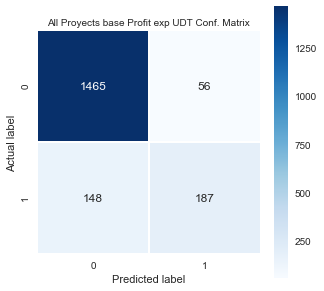

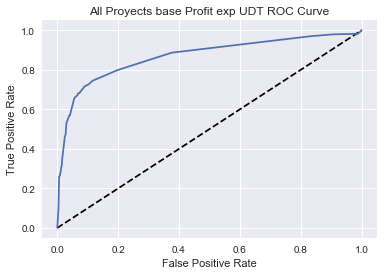

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 7, 'max_features': 18, 'min_samples_leaf': 2}
Best score is 0.8942432082794308
Best estimator is DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
            max_features=18, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [37]:
MODEL = 'UDT'
readme['model'][MODEL] = dict()
to_profit_curve[MODEL] = dict()
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3,5,10,15,20, None],
              "max_features": randint(1, 30),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

param_dist = {
    "max_depth": range(1,20),
    "max_features":range(1,30),
    "min_samples_leaf": range(1,10),
    "criterion": ["gini", "entropy"]
}

# Instantiate a Decision Tree classifier: tree
# tree = DecisionTreeClassifier(class_weight='balanced')
tree_clf = DecisionTreeClassifier()

# Stratified
from sklearn.model_selection import GridSearchCV, StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Instantiate the RandomizedSearchCV object: tree_cv
# tree_cv = RandomizedSearchCV(tree, param_dist, cv=kf)
tree_cv = GridSearchCV(tree_clf, param_dist, cv=kf, n_jobs=N_JOBS)

to_profit_curve[MODEL]['model'] = tree_cv
# Fit it to the data
tree_cv.fit(X,y)
grid_results(tree_cv)

# # Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))
print("Best estimator is {}".format(tree_cv.best_estimator_))

,importance,labels
3,0.520585,is_direccion
20,0.241552,San Andres Del Valle
15,0.051222,nro_cot_depto
7,0.044959,is_nrofam
14,0.025974,nro_cot_bod


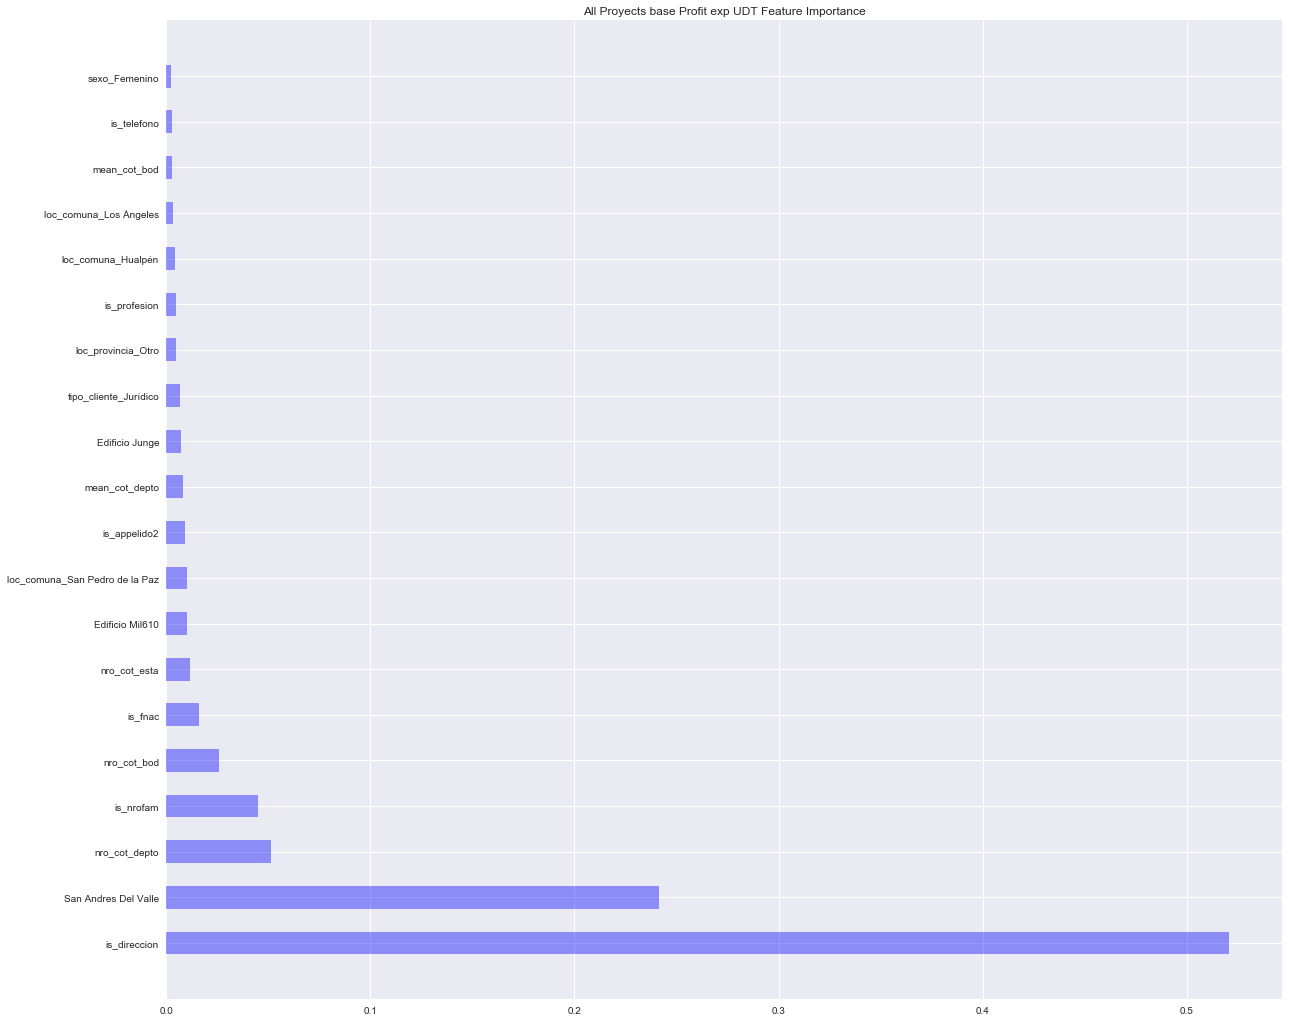

In [38]:
plot_importance_graph(tree_cv)

In [39]:
best_dt = tree_cv.best_estimator_

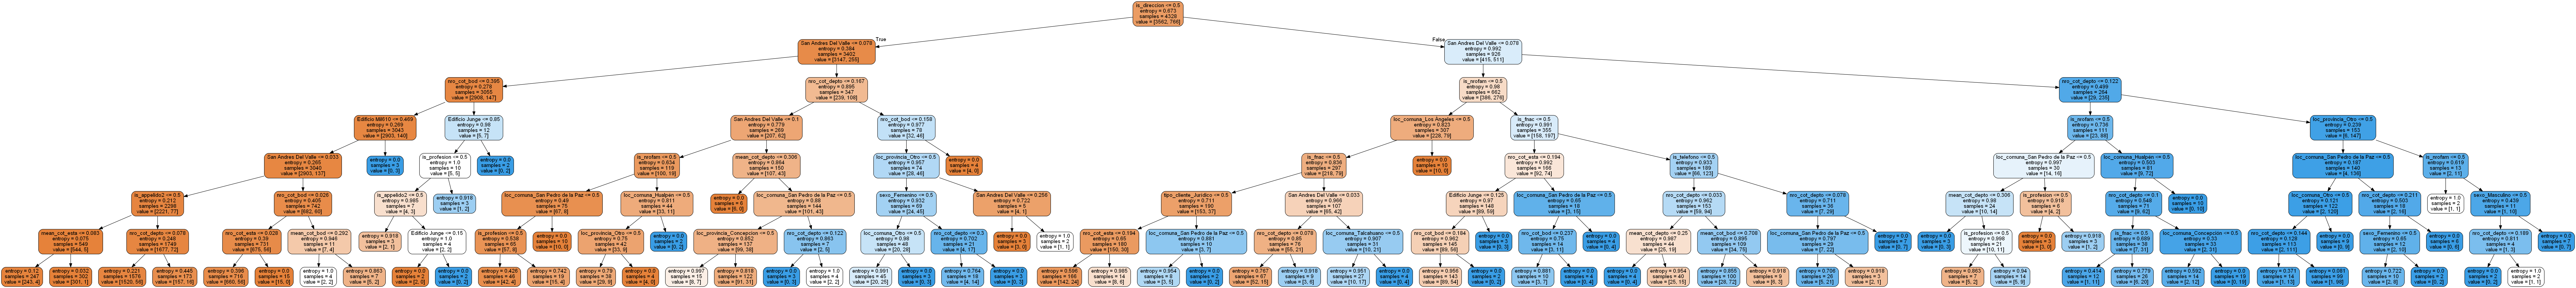

In [40]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import os, sys

def conda_fix(graph):
        path = os.path.join(sys.base_exec_prefix, "Library", "bin", "graphviz")
        paths = ("dot", "twopi", "neato", "circo", "fdp")
        paths = {p: os.path.join(path, "{}.exe".format(p)) for p in paths}
        graph.set_graphviz_executables(paths)

# visualize the decision tree
dot_data = StringIO()
export_graphviz(best_dt, out_file=dot_data, feature_names=personas.columns, filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
conda_fix(graph)
# graph.write_pdf("booking_tree.pdf")
Image(graph.create_png())

In [41]:
graph.write_pdf("..\\results\\model_results\\{}\\{}_decision_tree.pdf".format(DS_NAME,MODEL))

True

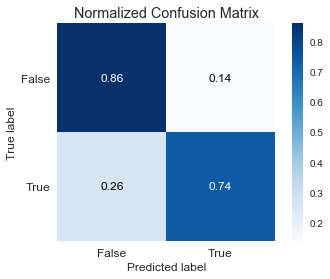

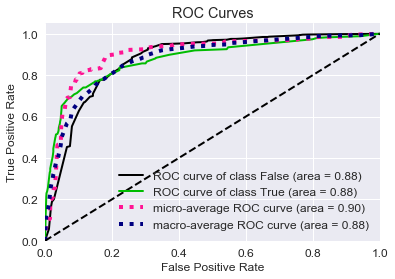

In [42]:
bdt_clf = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=7,
            max_features=26, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=9, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=RANDOM_STATE,
            splitter='best')

from sklearn.model_selection import cross_val_predict
predictions = cross_val_predict(bdt_clf, X, y)

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y, predictions, normalize=True)
plt.show()

bdt_clf.fit(X_train, y_train)
y_probas = bdt_clf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas)
plt.show()


# RandomForest

Current Bests:

## GRID Unbalanced

Best estimator is RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=28, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=7,
            min_samples_split=18, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Tuned Decision Tree Parameters: {'n_estimators': 80, 'min_samples_split': 18, 'min_samples_leaf': 7, 'max_features': 'auto', 'max_depth': 28, 'criterion': 'entropy', 'bootstrap': False}
Best score is 0.8953751617076326
Best score is 0.8953751617076326

[[1479   42]
 [ 151  184]]
             precision    recall  f1-score   support

      False       0.91      0.97      0.94      1521
       True       0.81      0.55      0.66       335

avg / total       0.89      0.90      0.89      1856



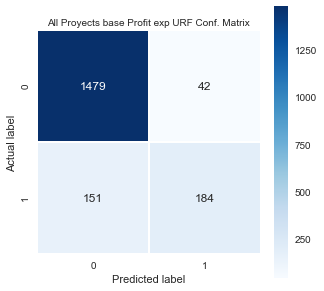

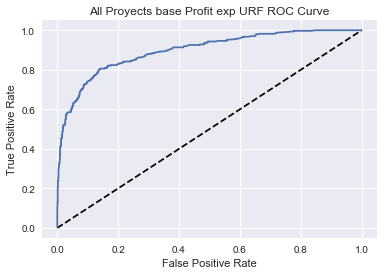

,importance,labels
3,0.280032,is_direccion
20,0.157812,San Andres Del Valle
15,0.146190,nro_cot_depto
4,0.141100,is_fnac
7,0.068834,is_nrofam


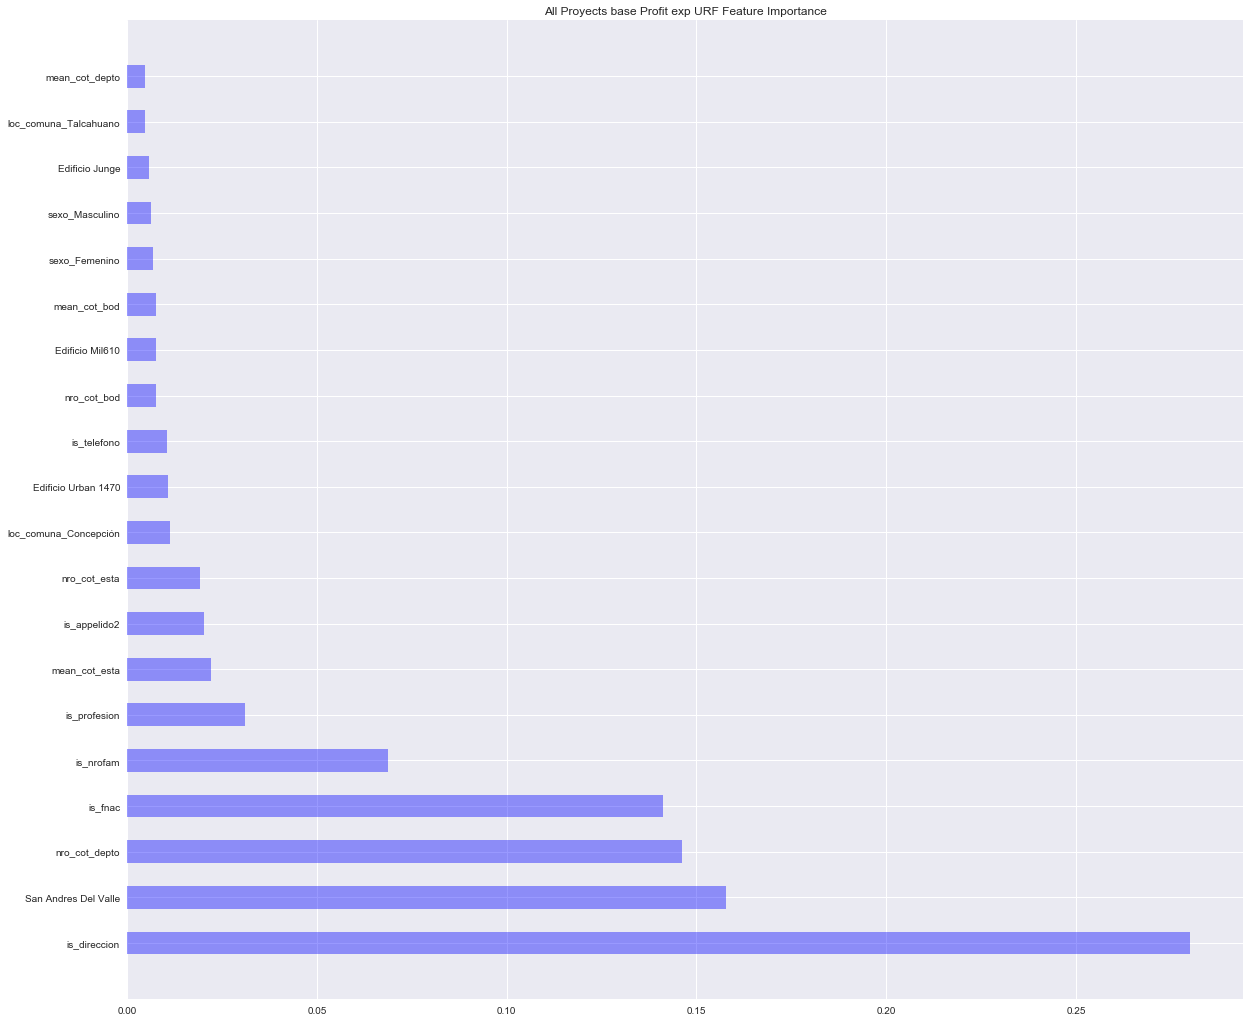

In [43]:
# Setup the parameters and distributions to sample from: param_dist
MODEL = 'URF'
readme['model'][MODEL] = dict()
param_grid = {
    "max_depth": randint(1,30),
    "max_features":randint(1,40),
    "min_samples_leaf": randint(1,20),
    "criterion": ["gini", "entropy"],
    "min_samples_split": randint(2,20),
    "n_estimators":[20,30,40,50,60,70,80,90,100],
    "bootstrap": [True, False],
}
param_grid = {"max_depth": list(range(1,30)),
              'max_features': ['auto', 'sqrt', 'log2'],
#               "max_features":range(1,40),
              "min_samples_split": list(range(2,30)),
              "min_samples_leaf": list(range(1,20)),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
             "n_estimators":list(range(20,100,10)),
#               "class_weight":[None,'balanced' ],
}

# Instantiate a Decision Tree classifier: tree
rf = RandomForestClassifier()

# Stratified
from sklearn.model_selection import GridSearchCV, StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Instantiate the RandomizedSearchCV object: tree_cv
rf_cv = RandomizedSearchCV(rf, param_grid, cv=kf, n_jobs=N_JOBS, n_iter=300)
# rf_cv = GridSearchCV(rf, param_grid, cv=kf, n_jobs=N_JOBS)

# Fit it to the data
rf_cv.fit(X,y)

# Predict
# y_pred = rf_cv.predict(X_test)

# Print the tuned parameters and score
print("Best estimator is {}".format(rf_cv.best_estimator_))
print("Tuned Decision Tree Parameters: {}".format(rf_cv.best_params_))
print("Best score is {}".format(rf_cv.best_score_))

grid_results(rf_cv)
plot_importance_graph(rf_cv)

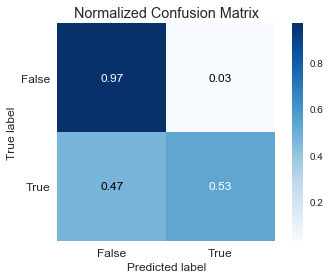

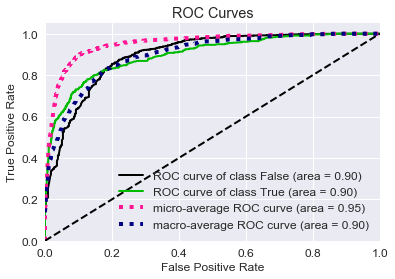

In [44]:
bdt_clf = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=26,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

from sklearn.model_selection import cross_val_predict
predictions = cross_val_predict(bdt_clf, X, y)

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y, predictions, normalize=True)
plt.show()

bdt_clf.fit(X_train, y_train)
y_probas = bdt_clf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas)
plt.show()

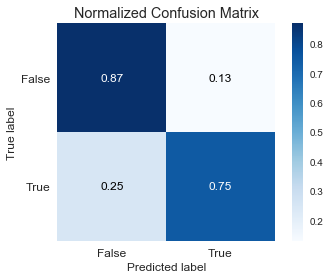

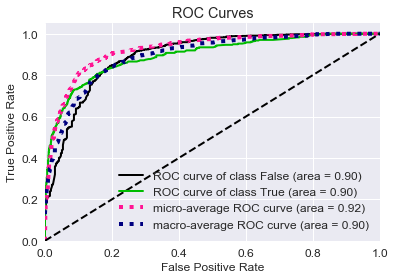

In [45]:
bdt_clf = RandomForestClassifier(bootstrap=False, class_weight='balanced', criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=26,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

from sklearn.model_selection import cross_val_predict
predictions = cross_val_predict(bdt_clf, X, y)

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y, predictions, normalize=True)
plt.show()

bdt_clf.fit(X_train, y_train)
y_probas = bdt_clf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas)
plt.show()

## GRID Balanced

Best Params:  {'min_samples_leaf': 7, 'max_features': 26, 'max_depth': 13, 'criterion': 'entropy'}
Best Estimator:  RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=13, max_features=26,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=7,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy:  0.8911637931034483
[[1318  203]
 [  78  257]]
             precision    recall  f1-score   support

      False       0.94      0.87      0.90      1521
       True       0.56      0.77      0.65       335

avg / total       0.87      0.85      0.86      1856



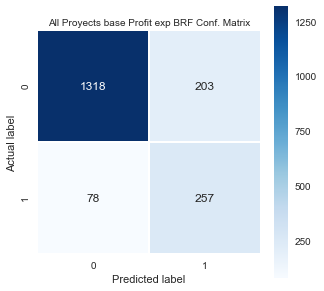

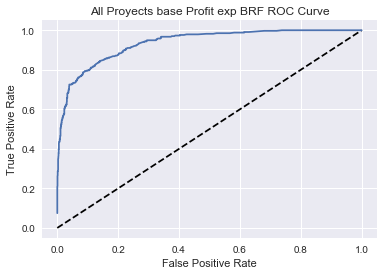

,importance,labels
3,0.390190,is_direccion
15,0.162380,nro_cot_depto
20,0.099400,San Andres Del Valle
4,0.063804,is_fnac
7,0.051520,is_nrofam


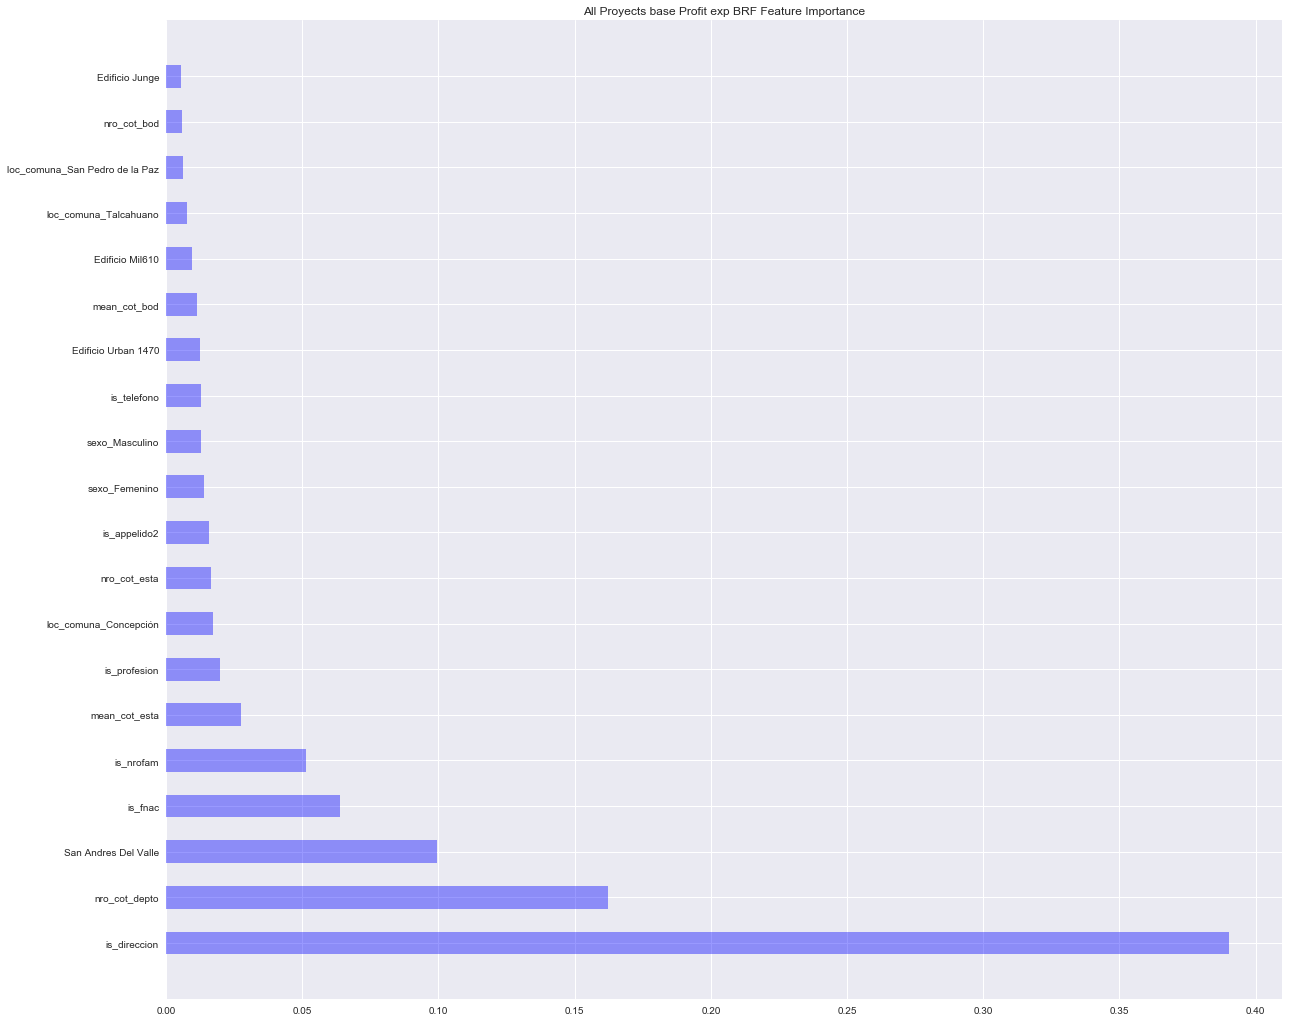

In [46]:
MODEL = 'BRF'
readme['model'][MODEL] = dict()
to_profit_curve[MODEL] = dict()

param_grid = {
    "max_depth": randint(1,30),
    "max_features":randint(1,40),
    "min_samples_leaf": randint(1,20),
    "criterion": ["gini", "entropy"],
    "min_samples_split": randint(2,20),
    "n_estimators":[20,30,40,50,60,70,80,90,100],
    "bootstrap": [True, False],
}

randomForest = RandomForestClassifier(class_weight='balanced')

# Stratified
from sklearn.model_selection import GridSearchCV, StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# RandomSearch
randomForest_cv = RandomizedSearchCV(randomForest, param_dist, cv=kf, n_jobs=N_JOBS,  random_state=RANDOM_STATE)

to_profit_curve[MODEL]['model'] = randomForest_cv
# Grid Search
# randomForest_cv = GridSearchCV(randomForest, param_grid, cv=kf, n_jobs=-1)

# Train
randomForest_cv.fit(X, y)

print("Best Params: ", randomForest_cv.best_params_)
print('Best Estimator: ', randomForest_cv.best_estimator_)

best_brf = randomForest_cv.best_estimator_
# Make predictions

score = best_brf.score(X_test, y_test)
print("Accuracy: ", score)

plot_confusion_matrix(best_brf, X_test, y_test, y_pred)

roc_curve_plot(best_brf, X_test, y_test)

plot_importance_graph(randomForest_cv)

In [47]:
brf_probs = best_brf.predict_proba(X_test)

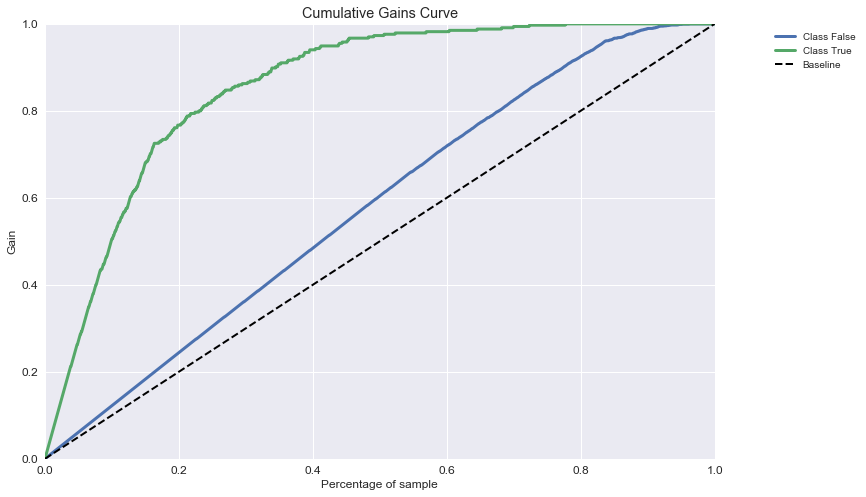

In [48]:
import scikitplot as skplt

fig = plt.figure()
ax = plt.subplot(skplt.metrics.plot_cumulative_gain(y_test, brf_probs, figsize=(12,8)))
plt.legend(loc=9, bbox_to_anchor=(1.15, 1), ncol=1)
plt.savefig('..\\results\\model_results\\{}\\{}_cum_gain.png'.format(DS_NAME, MODEL), bbox_inches = 'tight', dpi=300)
plt.show()


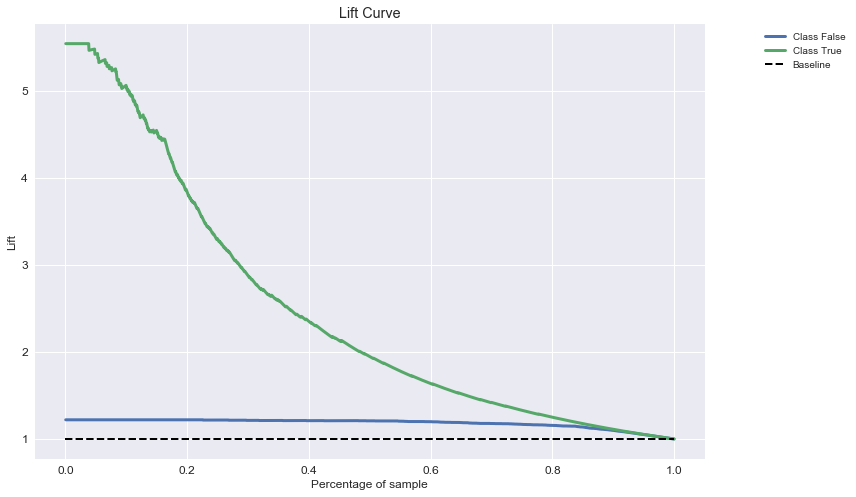

In [49]:
fig = plt.figure()
ax = plt.subplot(skplt.metrics.plot_lift_curve(y_test, brf_probs, figsize=(12,8)))
plt.legend(loc=9, bbox_to_anchor=(1.15, 1), ncol=1)
plt.savefig('..\\results\\model_results\\{}\\{}_lift.png'.format(DS_NAME, MODEL), bbox_inches = 'tight', dpi=300)
plt.show()

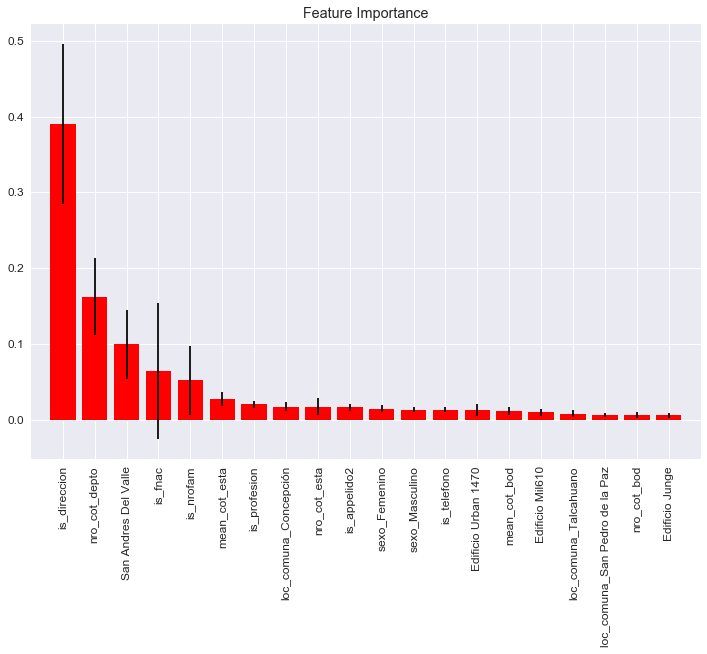

In [50]:
fig = plt.figure()
ax = plt.subplot(skplt.estimators.plot_feature_importances(
    best_brf, feature_names=personas.columns, x_tick_rotation=90, figsize=(12,8)))
plt.legend(loc=9, bbox_to_anchor=(1.15, 1), ncol=1)
plt.savefig('..\\results\\model_results\\{}\\{}_f_importance.png'.format(DS_NAME, MODEL), bbox_inches = 'tight', dpi=300)
plt.show()


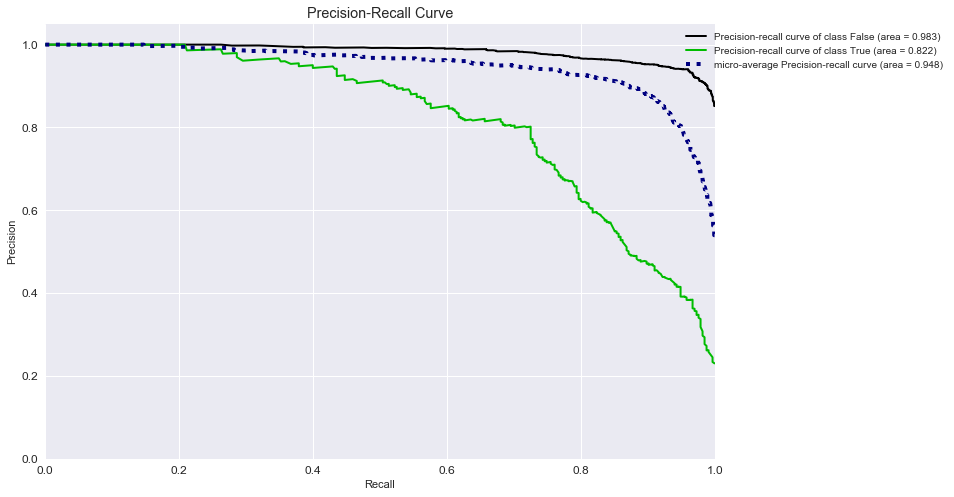

In [51]:

fig = plt.figure()
ax = plt.subplot(skplt.metrics.plot_precision_recall(y_test, brf_probs, figsize=(12,8)))
plt.legend(loc=9, bbox_to_anchor=(1.15, 1), ncol=1)
plt.savefig('..\\results\\model_results\\{}\\{}_precition_recall.png'.format(DS_NAME, MODEL), bbox_inches = 'tight', dpi=300)
plt.show()

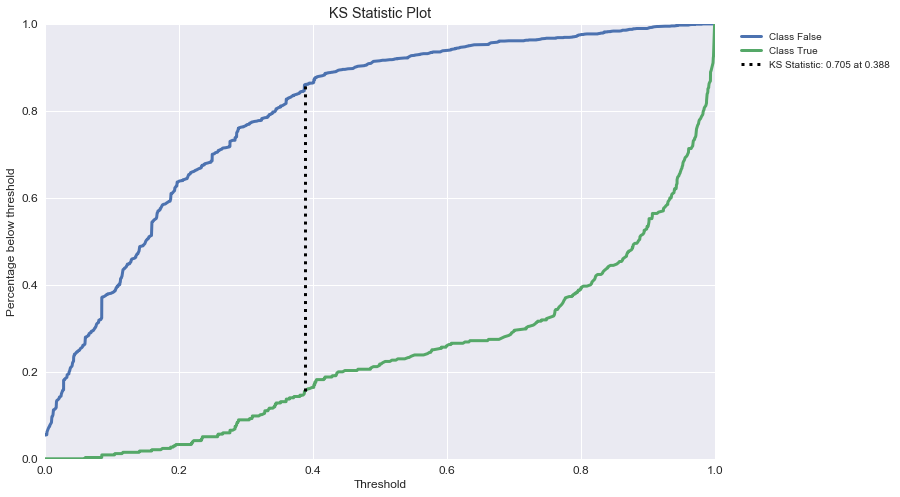

In [52]:
fig = plt.figure()
ax = plt.subplot(skplt.metrics.plot_ks_statistic(y_test, brf_probs, figsize=(12,8)))
plt.legend(loc=9, bbox_to_anchor=(1.15, 1), ncol=1)
plt.savefig('..\\results\\model_results\\{}\\{}_ks_sta.png'.format(DS_NAME, MODEL), bbox_inches = 'tight', dpi=300)
plt.show()

### 3.5.6 SVM

C:\Users\joaquin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\joaquin\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


{'C': 10, 'gamma': 0.1}
Tuned Logistic Regression Parameters: {'C': 10, 'gamma': 0.1}
Best score is 0.8609314359637775
Best score is 0.8609314359637775

[[1364  157]
 [  84  251]]
             precision    recall  f1-score   support

      False       0.94      0.90      0.92      1521
       True       0.62      0.75      0.68       335

avg / total       0.88      0.87      0.87      1856



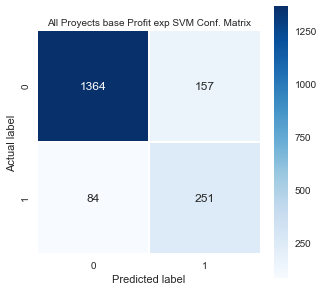

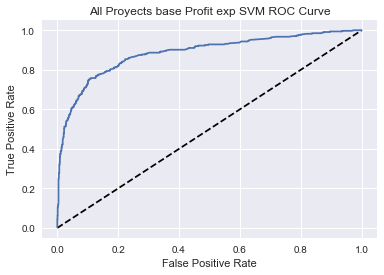

In [53]:
MODEL = 'SVM'
readme['model'][MODEL] = dict()

from sklearn import svm, grid_search

Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}

grid_search = GridSearchCV(svm.SVC(kernel='rbf', class_weight='balanced', probability=True), param_grid, cv=5, n_jobs=-1)

grid_search.fit(X, y)

print(grid_search.best_params_)


# y_pred = grid_search.predict(X)
# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(grid_search.best_params_)) 
print("Best score is {}".format(grid_search.best_score_))

grid_results(grid_search, plot_roc_curve=False)

# plot_confusion_matrix(grid_search, X , y, y_pred)
# plot_confusion_matrix(grid_search, X_test, y_test, y_pred)

roc_curve_plot(grid_search, X_test, y_test)

In [54]:
# MODEL = 'XGB'
# readme['model'][MODEL] = dict()

# from xgboost import XGBClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# n_estimators = [50, 100, 150, 200]
# max_depth = [2, 4, 6, 8]
# param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

# # fit model no training data
# xgb_clf = XGBClassifier()

# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
# xgb_grid = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)

# xgb_grid.fit(X_train, y_train)
# make predictions for test data
# y_pred = xgb_clf.predict(X_test)
# predictions = [round(value) for value in y_pred]
# # evaluate predictions
# accuracy = accuracy_score(y_test, predictions)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [55]:
# plot_confusion_matrix(xgb_grid, X_test, y_test, y_pred)

# roc_curve_plot(xgb_grid, X_test, y_test)

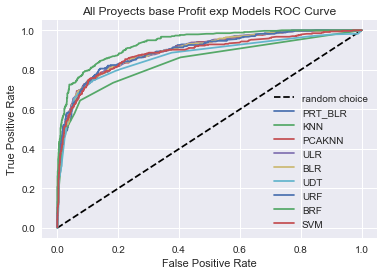

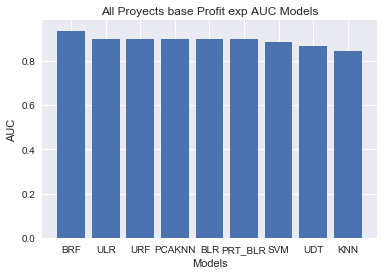

In [56]:
plot_all_roc_curves()
plot_all_auc_values()

In [57]:
roc_curves_to_plot.keys()

dict_keys(['All Proyects base Profit exp'])

In [58]:
# print(roc_curves_to_plot['Altos del Valle NN base']['BRF']['auc'])
# print(roc_curves_to_plot['Altos del Valle NN base_profesion']['BRF']['auc'])
# print(roc_curves_to_plot['Altos del Valle NN base_minusisprofesion']['BRF']['auc'])
# print(roc_curves_to_plot['Altos del Valle NN base_medini_isrec']['BLR']['auc'])

KeyError: 'Altos del Valle NN base'

In [59]:
#Cost assumptions
'''Cost of FP: 1, cost of FN: 2, cost of TN: 0, cost of TP: -1'''
cost_TP = 4; cost_FP = -5; cost_FN = 0; cost_TN = 0;
cb_matrix = -1*np.array([[cost_TP, cost_FP],[cost_FN, cost_TN]])

In [60]:
#Convert to standard confusion matrix
def standard_confusion_matrix(y_true, y_predict):
    TP = sum((y_true == 1) & (y_predict == 1))
    TN = sum((y_true == 0) & (y_predict == 0))
    FP = sum((y_true == 0) & (y_predict == 1))
    FN = sum((y_true == 1) & (y_predict == 0))
    
    return np.array([[TP,FP],[FN,TN]])

In [61]:
def profit_curve(cb, predict_probas, labels):
    indices = np.argsort(predict_probas)
    sorted_probs = predict_probas[indices]
    sorted_labels = labels.values[indices]
    profit_list = []
    
    for sp, sl in zip(sorted_probs, sorted_labels):
        predict_labels = sorted_probs > sp + .0001
        conf_mat = standard_confusion_matrix(sorted_labels, predict_labels)
        profit_list.append((cb * conf_mat).sum() / (len(labels)))
    
    return profit_list, sorted_probs

In [62]:
# Plot the profit curves
def plot_profit_curve(model, label, costbenefit, X_train, X_test, y_train, y_test, col):
    model.fit(X_train, y_train)
    predict_probas = model.predict_proba(X_test)[:,1]
    profit_list, sorted_probs = profit_curve(costbenefit, predict_probas, y_test)
    max_index = np.argmax(profit_list)
    max_threshold = sorted_probs[max_index]
    max_profit = profit_list[max_index]
    
    plt.plot(sorted_probs, profit_list, label=label, color=col, linewidth=3)
    plt.plot(max_threshold, max_profit, '.', color=col, markersize=18)

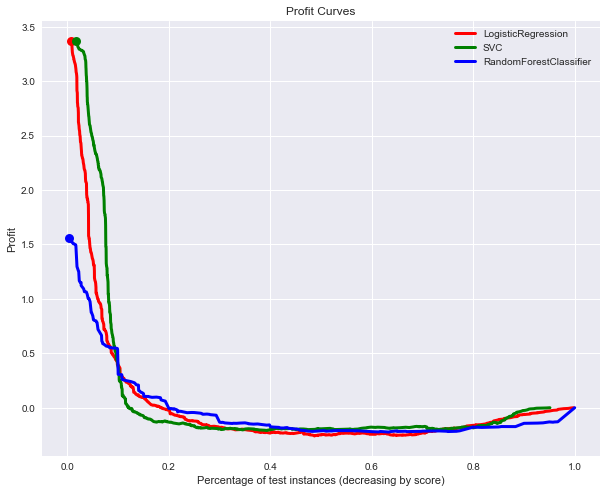

In [63]:
models = [LogisticRegression(), svm.SVC(probability=True), RandomForestClassifier()]

fig = plt.figure(figsize=(10,8))
# fig.set_facecolor('#F2F2F2')
colors = ['r', 'g', 'b', 'm']
for i, model in enumerate(models):
    plot_profit_curve(model, model.__class__.__name__, cb_matrix,
                      X_train, X_test, y_train, y_test, colors[i])

plt.title("Profit Curves")
plt.xlabel("Percentage of test instances (decreasing by score)")
plt.ylabel("Profit")
plt.legend(loc='best')
plt.savefig('Profit_curve.png', facecolor=fig.get_facecolor())
plt.show()

In [64]:
models = []
model_names = []
for key, value in to_profit_curve.items():
    models.append(value['model'])
    model_names.append(key)
    print(key, value['model'])

PRT_BLR LogisticRegression(C=0.4393970560760795, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
ULR LogisticRegression(C=3.727593720314938, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
BLR LogisticRegression(C=3.727593720314938, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
UDT GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeCla

IndexError: list index out of range

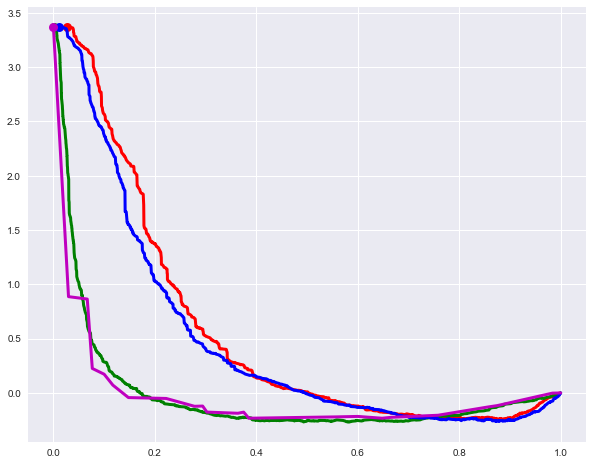

In [65]:
# models = [LogisticRegression(), svm.SVC(probability=True), RandomForestClassifier()]
# names =

fig = plt.figure(figsize=(10,8))
# fig.set_facecolor('#F2F2F2')
colors = ['r', 'g', 'b', 'm']
for i, model in enumerate(models):
#     plot_profit_curve(model, model.__class__.__name__, cb_matrix,
#                       X_train, X_test, y_train, y_test, colors[i])
    plot_profit_curve(model, model_names[i], cb_matrix,
                      X_train, X_test, y_train, y_test, colors[i])



In [ ]:
plt.title("Profit Curves")
plt.xlabel("Percentage of test instances (decreasing by score)")
plt.ylabel("Profit")
plt.legend(loc='best')
plt.savefig('Profit_curve.png', facecolor=fig.get_facecolor())
plt.show()